
# MODULO 07 - EJERCICIO 06-B
# ALEXIS YURI M.


Primero es necesario instalar y configurar PySpark en el notebook de Colab. Para eso se ejecutan las siguientes celdas para instalar las librerías necesarias y crear un contexto de Spark.




In [78]:
# Se instala PySpark y findspark
!pip install pyspark findspark

# Se inicializa findspark para encontrar la instalación de Spark.
import findspark
findspark.init()

# Se importa SparkContext.
from pyspark import SparkContext
from pyspark.sql import SparkSession

# Se crea una sesión de Spark si no existe.
try:
    spark.stop()
except:
    pass
spark = SparkSession.builder.master("local[*]").appName("Pipeline_kmeans").getOrCreate()

sc = spark.sparkContext

print("SparkSession está lista para usar.")

SparkSession está lista para usar.


Paso 1: Genera un dataset con al menos 3 variables numéricas (edad, ingresos, frecuencia de compra).


In [79]:
# Se crea un DataFrame simulado con datos numéricos.
data = spark.createDataFrame([
    (25, 30000, 10),
    (28, 35000, 12),
    (35, 60000, 5),
    (38, 65000, 6),
    (55, 120000, 2),
    (60, 150000, 1),
    (45, 90000, 8),
    (48, 95000, 7)
], ["edad", "ingresos", "frecuencia_compra"])

print("DataFrame creado:")
data.show()


# Se muestra la estructura del DataFrame.
data.printSchema()


DataFrame creado:
+----+--------+-----------------+
|edad|ingresos|frecuencia_compra|
+----+--------+-----------------+
|  25|   30000|               10|
|  28|   35000|               12|
|  35|   60000|                5|
|  38|   65000|                6|
|  55|  120000|                2|
|  60|  150000|                1|
|  45|   90000|                8|
|  48|   95000|                7|
+----+--------+-----------------+

root
 |-- edad: long (nullable = true)
 |-- ingresos: long (nullable = true)
 |-- frecuencia_compra: long (nullable = true)



Paso 2: Ensambla las features con VectorAssembler.


In [80]:
# Se importa la librería VectorAssembler.
from pyspark.ml.feature import VectorAssembler

# Secombinan las columnas características usando VectorAssembler.
assembler = VectorAssembler(
    inputCols=["edad", "ingresos", "frecuencia_compra"],
    outputCol="features"
)


Paso 3: Aplica el algoritmo KMeans().setK(4).


In [81]:
# Se importan las librerías del pipeline y del modelo Kmeans.
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline

# Se define el modelo Kmeans con 4 clusters.
kmeans = KMeans(featuresCol="features", k=4, seed=42)

# Se define el flujo de trabajo con Pipeline, uniendo Vectorassembler con el modelo Kmeans.
pipeline = Pipeline(stages=[assembler, kmeans])


Paso 4: Entrena el modelo y obtén las predicciones.

In [82]:
# Se entrena el Pipeline (se ajusta el VectorAssembler y entrena el modelo KMeans).
model = pipeline.fit(data)

# Se predicen los clústeres a los que pertenecen los clientes.
predictions = model.transform(data)



Paso 5: Muestra los clústeres con .show() y visualiza si es posible.

In [83]:
print("DataFrame con las predicciones de clúster:")
predictions.show(truncate=False)

DataFrame con las predicciones de clúster:
+----+--------+-----------------+-------------------+----------+
|edad|ingresos|frecuencia_compra|features           |prediction|
+----+--------+-----------------+-------------------+----------+
|25  |30000   |10               |[25.0,30000.0,10.0]|1         |
|28  |35000   |12               |[28.0,35000.0,12.0]|1         |
|35  |60000   |5                |[35.0,60000.0,5.0] |3         |
|38  |65000   |6                |[38.0,65000.0,6.0] |3         |
|55  |120000  |2                |[55.0,120000.0,2.0]|0         |
|60  |150000  |1                |[60.0,150000.0,1.0]|2         |
|45  |90000   |8                |[45.0,90000.0,8.0] |0         |
|48  |95000   |7                |[48.0,95000.0,7.0] |0         |
+----+--------+-----------------+-------------------+----------+



Paso 6: Calcula el ClusteringEvaluator con silhouette como métrica.

Silhouette Score: 0.6409631618980055
Interpretación: buena separación (≥ 0.5).

Centroides de los clusters:
Cluster 0: [4.93333333e+01 1.01666667e+05 5.66666667e+00]
Cluster 1: [2.65e+01 3.25e+04 1.10e+01]
Cluster 2: [6.0e+01 1.5e+05 1.0e+00]
Cluster 3: [3.65e+01 6.25e+04 5.50e+00]
+----------+-----+
|prediction|count|
+----------+-----+
|         1|    2|
|         3|    2|
|         2|    1|
|         0|    3|
+----------+-----+



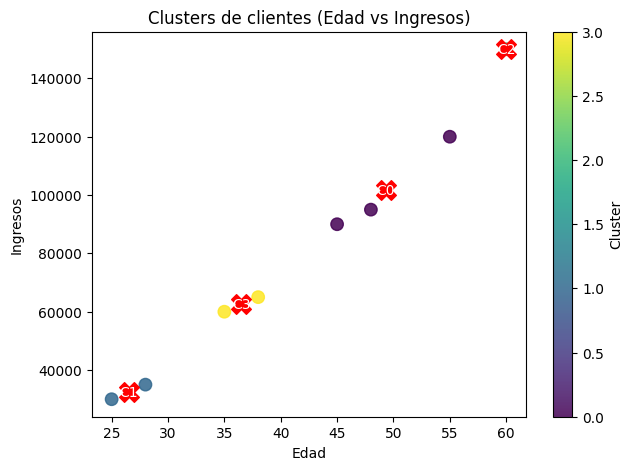

In [84]:
# Se importa la librería ClusteringEvaluator.
from pyspark.ml.evaluation import ClusteringEvaluator

# Se evalua el modelo con silhouette.
evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="prediction")
silhouette_score = evaluator.evaluate(predictions)

print('Silhouette Score:', silhouette_score)
if silhouette_score >= 0.5:
    print('Interpretación: buena separación (≥ 0.5).')
elif silhouette_score >= 0.25:
    print('Interpretación: separación moderada (0.25–0.5).')
else:
    print('Interpretación: separación pobre (< 0.25).')


print('\nCentroides de los clusters:')
for i, c in enumerate(model.stages[-1].clusterCenters()):
    print(f'Cluster {i}:', c)
predictions.groupBy('prediction').count().show()



import matplotlib.pyplot as plt
pdf = predictions.select('edad','ingresos','prediction').toPandas()
plt.figure(figsize=(7,5))
scatter = plt.scatter(pdf['edad'], pdf['ingresos'], c=pdf['prediction'], cmap='viridis', s=80, alpha=0.85)
for idx, (cx, cy, _cz) in enumerate(model.stages[-1].clusterCenters()):
    plt.scatter(cx, cy, marker='X', s=200, c='red')
    plt.text(cx, cy, f'C{idx}', ha='center', va='center', color='white')
plt.xlabel('Edad')
plt.ylabel('Ingresos')
plt.title('Clusters de clientes (Edad vs Ingresos)')
plt.colorbar(scatter, label='Cluster')
plt.show()





Paso 7: Interpretación de los resultados.

Interpretación del Silhouette Score:

El Silhouette Score es una métrica que mide la cohesión y separación de los clústers. En otras palabras, nos dice qué tan bien definidos están los grupos que el algoritmo ha encontrado. Su valor varía entre -1 y +1.

Un puntaje alto (cercano a 1.0), indica que cada objeto está bien agrupado en su propio clúster y que su clúster está bien separado de los demás. En el ejemplo, un puntaje como 0.6410 sería bueno (≥ 0.5).


Interpretación de Centroides:

- Representan el “promedio” de cada clúster (edad, ingresos, frecuencia).

- Gráfico Edad vs Ingresos: muestra como los clientes se agrupan. Cada color es un clúster y la X roja es su centroide.

- Interpretación:
  - Hay un grupo de jóvenes con ingresos bajos.
  - Un grupo intermedio con ingresos medios.
  - Un grupo de transición (adultos son ingresos medio-alto).
  - Y un grupo de adultos mayores con ingresos altos.




In [85]:
spark.stop()
print('Spark detenido.')

Spark detenido.
